 # Predicting the Stock Market
 In this project, we will build a linear regression model to predict the index price of the S&P 500.

 __Disclaimer:__ You should not make trades with any models developed in this mission. The disclaimer on from the website that this guide says as much. The developer who wrote this also has virtually no experience in finance. The material contained in this project does not contain trading advice. Only one's curiosity about how models work.

In [1]:
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import seaborn as sns

stocks = pd.read_csv('data/sphist.csv')
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks = stocks.set_index('Date').sort_values('Date')
stocks.head(10)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000
1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001
1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000
1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000
1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000


 ### An Important Note About Stock Market Data
 Stock market data is sequential (ie time series), and each observation of a particular day comes after the previous day, meaning that each row is not an independent observation.
 This means it is easier to accidentally inject _future_ knowledge into past observations if we're not careful.
 Several of the features/indicators we'll create involve something to the degree of average price of the last _n_ days. When computing these, we have to becareful that the current day is not included in this measure.
 For example, if we're computing the average price of the last 5 days from 1995-09-25, then we need to make sure that 1995-09-25 is not in included in the calculation.

In [2]:
indicators = pd.DataFrame()
intervals = [5, 30, 365]
base_features = ['Close', 'Volume']

def generate_features(df, interval, measures):
    for measure in measures:
        for interval in intervals:
            indicators[f'avg_{measure.lower()}_last_{interval}_day'] = df[measure].rolling(f'{interval}D').mean().shift(axis=0, periods=1)
            indicators[f'stdev_{measure.lower()}_last_{interval}_day'] = df[measure].rolling(f'{interval}D').std().shift(axis=0, periods=1)

generate_features(stocks, intervals, base_features)

indicators['avg_ratio_close_5_365_day'] = indicators['avg_close_last_5_day'] / indicators['avg_close_last_365_day']
indicators['avg_ratio_volume_5_365_day'] = indicators['avg_volume_last_5_day'] / indicators['avg_volume_last_365_day']
print(indicators.columns)

Index(['avg_close_last_5_day', 'stdev_close_last_5_day',
       'avg_close_last_30_day', 'stdev_close_last_30_day',
       'avg_close_last_365_day', 'stdev_close_last_365_day',
       'avg_volume_last_5_day', 'stdev_volume_last_5_day',
       'avg_volume_last_30_day', 'stdev_volume_last_30_day',
       'avg_volume_last_365_day', 'stdev_volume_last_365_day',
       'avg_ratio_close_5_365_day', 'avg_ratio_volume_5_365_day'],
      dtype='object')


 Next, we'll take a look at the ratio between the low and high prices in the past year compared to the current price

In [3]:
year_min_max = pd.DataFrame()
year_min_max['min'] = stocks.groupby(pd.Grouper(freq='Y'))['Close'].min()
year_min_max['max'] = stocks.groupby(pd.Grouper(freq='Y'))['Close'].max()
year_min_max['year'] = year_min_max.index.year
year_min_max.index = year_min_max['year']
year_min_max = year_min_max.drop('year', axis=1)
indicators['year'] = indicators.index.year

num_rows_first_year = indicators[indicators['year'] == 1950].shape[0]
indicators['prev_year_close_min'] = indicators['year'].apply(lambda y: year_min_max.loc[y, 'min']).shift(axis=0, periods=num_rows_first_year)
indicators['prev_year_close_max'] = indicators['year'].apply(lambda y: year_min_max.loc[y, 'max']).shift(axis=0, periods=num_rows_first_year)

indicators['close'] = stocks['Close']
indicators['ratio_prev_year_low_to_current_close'] = indicators['prev_year_close_min'] / indicators['close']
indicators['ratio_prev_year_high_to_current_close'] = indicators['prev_year_close_max'] / indicators['close'] 
indicators = indicators.drop(['close'], axis=1)

 Going off on conventional knowledge, the value of the stock market in general has only increased, meaning we can expect that the year would have a large effect on the price.
 Instead of using the year as it is presented, we'll subtract all year values by 1950 so that 1950 will be year 0 and 2000 will be 50.

In [4]:
indicators['year'] = indicators['year'] - 1950

In [5]:
indicators.describe()

,avg_close_last_5_day,stdev_close_last_5_day,avg_close_last_30_day,stdev_close_last_30_day,avg_close_last_365_day,stdev_close_last_365_day,avg_volume_last_5_day,stdev_volume_last_5_day,avg_volume_last_30_day,stdev_volume_last_30_day,avg_volume_last_365_day,stdev_volume_last_365_day,avg_ratio_close_5_365_day,avg_ratio_volume_5_365_day,year,prev_year_close_min,prev_year_close_max,ratio_prev_year_low_to_current_close,ratio_prev_year_high_to_current_close
count,16589.000000,1.658100e+04,16589.000000,16588.000000,16589.000000,16588.000000,1.658900e+04,1.658100e+04,1.658900e+04,1.658800e+04,1.658900e+04,1.658800e+04,16589.000000,16589.000000,16590.000000,16341.000000,16341.000000,16341.000000,16341.000000
mean,482.437072,3.519508e+00,481.337312,7.895678,467.147921,27.805077,7.868079e+08,8.790527e+07,7.916890e+08,1.239114e+08,7.658811e+08,1.577866e+08,1.038079,1.052747,32.505244,399.536443,507.589033,0.826254,1.041145
std,554.704657,5.862782e+00,553.432385,11.196052,537.058725,36.594577,1.432393e+09,2.065323e+08,1.427986e+09,2.546871e+08,1.391746e+09,3.112765e+08,0.087551,0.221545,19.018009,460.087248,575.978149,0.129277,0.161610
min,16.660000,6.497936e-08,16.660000,0.083972,16.660000,0.127711,7.550000e+05,0.000000e+00,9.109091e+05,1.064093e+05,1.227831e+06,2.407836e+05,0.606686,0.260032,0.000000,16.660000,20.430000,0.534368,0.742205
25%,83.939999,3.023793e-01,83.988571,0.926214,83.911067,3.652660,7.852000e+06,6.530952e+05,7.980476e+06,1.198585e+06,7.487154e+06,1.649105e+06,0.989407,0.907254,16.000000,70.040001,93.459999,0.737208,0.946593
50%,143.370000,8.980228e-01,141.670953,2.408601,130.392698,8.979635,7.416667e+07,6.919220e+06,8.052727e+07,1.190729e+07,6.693531e+07,1.530144e+07,1.047687,1.032421,33.000000,112.769997,143.020004,0.817068,1.003452
75%,950.503336,4.180899e+00,944.353638,11.949715,947.217422,44.817664,7.771667e+08,6.375244e+07,7.946076e+08,1.091190e+08,7.557069e+08,1.225855e+08,1.095872,1.165625,49.000000,737.010010,1111.920044,0.895021,1.096168
max,2128.425049,7.135634e+01,2112.883370,118.355682,2061.330676,238.866768,9.328214e+09,2.558693e+09,7.658786e+09,2.297185e+09,6.089097e+09,1.607490e+09,1.251535,3.199168,65.000000,1741.890015,2090.570068,1.826219,2.139092


In [6]:
stocks = pd.merge(stocks, indicators, left_on='Date', right_on='Date')

In [7]:
stocks.head()

,Open,High,Low,Close,Volume,Adj Close,avg_close_last_5_day,stdev_close_last_5_day,avg_close_last_30_day,stdev_close_last_30_day,...,stdev_volume_last_30_day,avg_volume_last_365_day,stdev_volume_last_365_day,avg_ratio_close_5_365_day,avg_ratio_volume_5_365_day,year,prev_year_close_min,prev_year_close_max,ratio_prev_year_low_to_current_close,ratio_prev_year_high_to_current_close
Date,,,,,,,,,,,,,,,,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85,16.660000,NaN,16.660000,NaN,...,NaN,1260000.0,NaN,1.0,1.0,0,NaN,NaN,NaN,NaN
1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93,16.755000,0.134350,16.755000,0.134350,...,445477.272148,1575000.0,445477.272148,1.0,1.0,0,NaN,NaN,NaN,NaN
1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98,16.813333,0.138684,16.813333,0.138684,...,645058.136915,1900000.0,645058.136915,1.0,1.0,0,NaN,NaN,NaN,NaN
1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08,16.855000,0.140594,16.855000,0.140594,...,529551.697193,1927500.0,529551.697193,1.0,1.0,0,NaN,NaN,NaN,NaN


 While pandas is still able to calculated a rolling window if there isn't enough days, this isn't good enough for what we need. We have to drop columns that are older than a year old.
 We'll also drop columns with NA values, as well as any columns we used primarily to create other columns.

In [8]:
stocks = stocks[stocks.index > datetime(year=1951, month=1, day=2)]
stocks = stocks.drop(['prev_year_close_min', 'prev_year_close_max'], axis=1)
stocks = stocks.dropna(axis=0)

 With our features in line, let's display some of the data graphically to get an idea of how they interact with the closing price

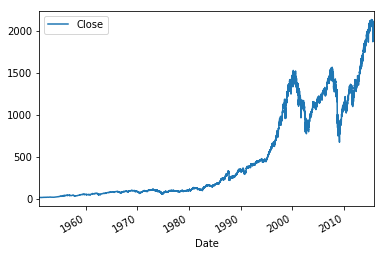

In [9]:
stocks.plot.line(y='Close', use_index=True)

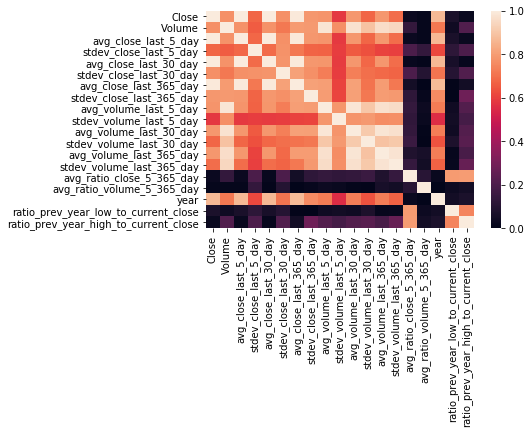

In [10]:
sns.heatmap(stocks.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1).corr().abs())

 ### Running the Model
 Before training our model, we'll want to define something that we can evaluate our model's performance on.
 _Mean Squared Error_ is a common metric. However, because it squares the error, it is harder for us to tell intuitively how far we are from the true price.
 In this project, the metric that will be used is _Mean Absolute Error_. This metric may be more suited for time series data, and it is also more intuitive in telling us how far off from the true price we are.

 As we examined, the avg ratios 5-365 days and ratio between high/low and current price appear to have very little correlation, so we'll drop those...

In [11]:
# last index of columns in original data is 5
X = stocks.columns[6:].to_list()
X = [c for c in X if c not in ('avg_ratio_close_5_365_day', 'avg_ratio_volume_5_365_day', 'ratio_prev_year_low_to_current_close', 'ratio_prev_year_high_to_current_close')]
print(X)

['avg_close_last_5_day', 'stdev_close_last_5_day', 'avg_close_last_30_day', 'stdev_close_last_30_day', 'avg_close_last_365_day', 'stdev_close_last_365_day', 'avg_volume_last_5_day', 'stdev_volume_last_5_day', 'avg_volume_last_30_day', 'stdev_volume_last_30_day', 'avg_volume_last_365_day', 'stdev_volume_last_365_day', 'year']


Because we are making predictions using a time series dataset, we'll want to split our train and test date based on the data

In [12]:
train = stocks[stocks.index < datetime(year=2013, month=1, day=1)]
test = stocks[stocks.index >= datetime(year=2013, month=1, day=1)]

In [13]:
y = ['Close']
reggie = LinearRegression().fit(train[X], train[y])
predictions = reggie.predict(test[X])
mae = mean_absolute_error(test[y], predictions)
r2 = r2_score(test[y], predictions)

In [14]:
print("Mean Absolute Error:", mae)
print("Variance Score:", r2)

Mean Absolute Error: 14.358852219525867
Variance Score: 0.9888640530406666


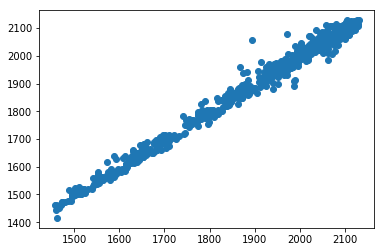

In [15]:
# ### Plotting Actual vs Predictions
plt.scatter(test[y], predictions)

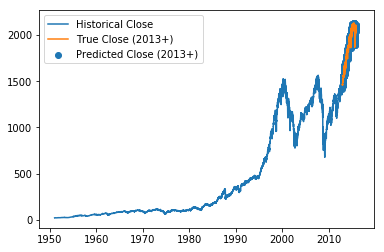

In [16]:
# ### Plotting Predictions
test_with_predictions = test.copy()
test_with_predictions['predicted'] = predictions

plt.plot(train.index, train['Close'], label="Historical Close")
plt.plot(test.index, test['Close'], label="True Close (2013+)")
plt.scatter(test_with_predictions.index, test_with_predictions['predicted'], label="Predicted Close (2013+)")
plt.legend()

 ### Conclusion
 The model gives us an MAE of about $14.36 and an R2 score that is very close to zero. While the numbers look great, the fact that our error is this immediately raises some flags.
 - Did we overfit the model?
 - Is this sample a random walk?
 Further evaluation of the model and data is required.

 As for improving the model itself, some ideas include:
 - Add more features, including
   - Date components (day, week, month, holidays in the previous month)
   - Other features not mentoined
   - Incorporate outside data into this analysis
 - Make predictions only one day head
   - To do this we would train the model using 1951-01-03 to 2013-01-02 to make predictions for 1951-01-03
   - Then we add the past day's data (2013-01-03) and use it to predict data for January 4th, and so on